In [8]:
%matplotlib inline
import pydsd as pyd
import pytmatrix as pyt
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

This notebook does some of the data generation that we will use in the short course. 

# Disdrometer Scattering
First we will take some randomly generated DSDs, then do some scattering to give us a trainable radar dataset. 

In [2]:
from pytmatrix.tmatrix import Scatterer
from pytmatrix.psd import PSDIntegrator, GammaPSD
from pytmatrix import orientation, radar, tmatrix_aux, refractive
from pydsd import DSR

In [36]:
class DSDProcessor(object):
    def calcParameters(self, D0, Nw, mu):
        self.moments = {}
        self.scatterer.psd = GammaPSD(D0=D0, Nw=10 ** (Nw), mu=mu)
        self.scatterer.set_geometry(tmatrix_aux.geom_horiz_back)
        self.moments["Zh"] = 10 * np.log10(radar.refl(self.scatterer))
        self.moments["Zdr"] = 10 * np.log10(radar.Zdr(self.scatterer))
        self.moments["delta_hv"] = radar.delta_hv(self.scatterer)
        self.moments["ldr_h"] = radar.ldr(self.scatterer)
        self.moments["ldr_v"] = radar.ldr(self.scatterer, h_pol=False)

        self.scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
        self.moments["Kdp"] = radar.Kdp(self.scatterer)
        self.moments["Ah"] = radar.Ai(self.scatterer)
        self.moments["Adr"] = self.moments["Ah"] - radar.Ai(self.scatterer, h_pol=False)
        return self.moments
    
    
    def returns_as_array(self, dsd):
        ''' This just splits the return dictionary into an array to make a few things easier. '''
        D0, Nw, mu = dsd
        moment = self.calcParameters(D0, Nw, mu)
        
        return [
            moment['Zh'], moment['Zdr'], moment['delta_hv'], moment['ldr_h'], moment['ldr_v'],
            moment['Kdp'], moment['Ah'], moment['Adr']
        ]
    
    def calcParametersBatch(self, D0, Nw, mu):
        ''' Same as calcParameters but with arrays instead of singletons'''
        moments = np.array(list(map(self.returns_as_array, zip(D0, Nw, mu))))
        return moments

    def __init__(self, wl=tmatrix_aux.wl_X, dr=1, shape="bc", canting_angle=7.0):
        DSR_list = {"tb": DSR.tb, "bc": DSR.bc, "pb": DSR.pb}

        self.scatterer = Scatterer(wavelength=wl, m=refractive.m_w_10C[wl])
        self.scatterer.psd_integrator = PSDIntegrator()
        self.scatterer.psd_integrator.axis_ratio_func = lambda D: 1.0 / DSR_list[shape](
            D
        )
        self.scatterer.psd_integrator.D_max = 10.0
        self.scatterer.psd_integrator.geometries = (
            tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw
        )
        self.scatterer.or_pdf = orientation.gaussian_pdf(canting_angle)
        self.scatterer.orient = orientation.orient_averaged_fixed
        self.scatterer.psd_integrator.init_scatter_table(self.scatterer)
        self.dr = dr


In [37]:
dsd_processor = DSDProcessor() # Default X band for first dataset is fine. 

In [38]:
dsd_processor.calcParameters(2, 3, 3)

{'Zh': 39.7458149046063,
 'Zdr': 1.996043027211839,
 'delta_hv': 0.0496025306331171,
 'ldr_h': 0.0008489197364380117,
 'ldr_v': 0.0013442217967929166,
 'Kdp': 0.4497729220778618,
 'Ah': 0.11003969286657221,
 'Adr': 0.01797479405421047}

Now we just generate a large number of these and save them out. We should probably do some filtering based on rain rate as well. 

In [41]:
moments = dsd_processor.calcParametersBatch([1, 2, 3, 1], [1, 2, 3, 2], [3, 2, 1, 3])

In [50]:
D0 = np.random.uniform(0.01, 5, 50000)
Nw = np.random.uniform(0.01, 5, 50000)
mu = np.random.uniform(1, 6, 50000)

In [51]:
moments= dsd_processor.calcParametersBatch(D0, Nw, mu)

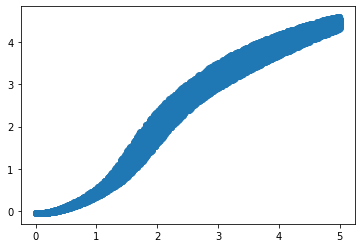

In [49]:
plt.scatter(D0, moments[:,1])

Now let's write these out into a netCDF file so we can reuse these later on.    
_Note: We should add other canting angles, and DSRs later on._

In [54]:
rootgrp = Dataset("x_scattered_dsds.nc", "w", format="NETCDF4")
rootgrp.createDimension("sample", None)
D0_f = rootgrp.createVariable("D0","f8",("sample",))
Nw_f = rootgrp.createVariable("Nw","f8",("sample",))
mu_f = rootgrp.createVariable("mu","f8",("sample",))

Zh_f = rootgrp.createVariable("Zh","f8",("sample",))
Zdr_f = rootgrp.createVariable("Zdr","f8",("sample",))
delta_f = rootgrp.createVariable("delta","f8",("sample",))
ldrh_f = rootgrp.createVariable("ldrh","f8",("sample",))
ldrv_f = rootgrp.createVariable("ldrv","f8",("sample",))
Kdp_f = rootgrp.createVariable("Kdp","f8",("sample",))
Ah_f = rootgrp.createVariable("Ah","f8",("sample",))
Adr_f = rootgrp.createVariable("Adr","f8",("sample",))

In [57]:
D0_f[:] = D0
Nw_f[:] = Nw
mu_f[:] = mu

Zh_f[:] = moments[:,0]
Zdr_f[:] = moments[:,1]
delta_f[:] = moments[:,2]
ldrh_f[:] = moments[:,3]
ldrv_f[:] = moments[:,4]
Kdp_f[:] = moments[:,5]
Ah_f[:] = moments[:,6]
Adr_f[:] = moments[:,7]

rootgrp.close()